In [145]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

import random

#

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix

#

from bayes_opt import BayesianOptimization

#

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from cartopy.io.img_tiles import GoogleTiles

from pandasgui import show

#

import warnings

In [146]:
gmID_list = cfs.list_whitelisted_gmIDs_with_traffic_data()

topic_list = cfs.list_topics()

print( topic_list )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [147]:
moving_window = 10 # seconds

expansion_window = 1e9 # nanoseconds

#

red_preprocessed_dfs = []

green_preprocessed_dfs = []

blue_preprocessed_dfs = []

for gmID in gmID_list:

    preprocessed_df = cfs.retrieve_gmID_preprocessed_moving_data( gmID, window_seconds = moving_window )

    #

    cfs.BinaryDisengagementExpanded( preprocessed_df, moving_colname = 'time', window = expansion_window )

    #

    cfs.DisengagementID( preprocessed_df, expanded = False )

    cfs.DisengagementID( preprocessed_df, expanded = True )

    #

    if ( cfs.give_route( gmID ) == 'Red' ):

        red_preprocessed_dfs.append( preprocessed_df )

    elif ( cfs.give_route( gmID ) == 'Green' ):

        green_preprocessed_dfs.append( preprocessed_df )

    elif ( cfs.give_route( gmID ) == 'Blue' ):

        blue_preprocessed_dfs.append( preprocessed_df )

In [148]:
red_train_gmIDs = [ 
'61b12e7a-f234-11ee-bb33-fb353e7798cd',
'fcc6fcd2-f013-11ee-b966-fb353e7798cd',
'05c7c824-cab8-11ee-aa4d-1d66adf2f0c7',
'211bdb36-f0da-11ee-ba1b-fb353e7798cd',
'868de15e-f3b3-11ee-bb4e-fb353e7798cd',
'72a03d4a-efe9-11ee-b966-fb353e7798cd',
'7fb7b9c0-c881-11ee-a7fc-dd032dba19e8',
'96f7a614-f549-11ee-8afa-cb629b0d53e6',
'1bbbfbae-c839-11ee-a7fc-dd032dba19e8',
'622bd2e8-f0e4-11ee-ba1f-fb353e7798cd',
'9798fe24-f143-11ee-ba78-fb353e7798cd',
'88dd6fbe-f224-11ee-bb21-fb353e7798cd',
'c9c6856c-d33c-11ee-b437-336917683bb8',
'd12cd1c4-caec-11ee-909c-e1dc60cf66f9',
'817d6848-efb6-11ee-b966-fb353e7798cd',
'1b6aca0e-efdf-11ee-b966-fb353e7798cd',
'41b67a28-f52f-11ee-8afa-cb629b0d53e6',
'fc211bb2-efca-11ee-b966-fb353e7798cd',
'84d96f18-f214-11ee-bb13-fb353e7798cd',
'fe973c9c-f53c-11ee-8afa-cb629b0d53e6',
'3151e9e2-eff3-11ee-b966-fb353e7798cd',
'c0555ef0-f50f-11ee-8afa-cb629b0d53e6',
'f711e68e-f0e1-11ee-ba1f-fb353e7798cd',
'c338788a-d324-11ee-b437-336917683bb8',
'd21965e6-f0fa-11ee-ba37-fb353e7798cd',
'88a68dd8-eef9-11ee-9385-ef789ffde1d3',
'f41cbd44-eff8-11ee-b966-fb353e7798cd',
'43a1a35e-f362-11ee-bb4e-fb353e7798cd',
'6d2ea45a-c839-11ee-a7fc-dd032dba19e8',
'01e65360-efd4-11ee-b966-fb353e7798cd',
'7cbd932e-f244-11ee-bb3f-fb353e7798cd',
'65cfbfd6-f396-11ee-bb4e-fb353e7798cd',
'94c53148-eeed-11ee-9385-ef789ffde1d3',
'fd1ab258-efa7-11ee-b966-fb353e7798cd',
'e7b934a8-ef1a-11ee-9385-ef789ffde1d3',
'de933de8-f112-11ee-ba4d-fb353e7798cd',
'd3698592-ef9d-11ee-b966-fb353e7798cd',
'dd72fdec-f0cf-11ee-ba0d-fb353e7798cd',
'b82476fe-f1f3-11ee-baff-fb353e7798cd',
'f755cf60-f132-11ee-ba6d-fb353e7798cd',
'853ef120-cad3-11ee-909c-e1dc60cf66f9',
'f0eebb6a-f0dc-11ee-ba1e-fb353e7798cd',
'cf831f42-f353-11ee-bb4e-fb353e7798cd',
'ecebb942-f162-11ee-ba97-fb353e7798cd',
'219f7eb8-ef87-11ee-b966-fb353e7798cd',
'd24820c8-f197-11ee-babe-fb353e7798cd',
'3d2d29ec-ef95-11ee-b966-fb353e7798cd',
'457dc5ee-f02a-11ee-b966-fb353e7798cd',
'2462c9d0-eecd-11ee-9385-ef789ffde1d3',
'51ef6da6-ca9f-11ee-909c-e1dc60cf66f9',
'c25271be-f3a4-11ee-bb4e-fb353e7798cd',
'8347b862-efad-11ee-b966-fb353e7798cd',
'8dbbbf1c-f0ef-11ee-ba29-fb353e7798cd',
'9189a2a8-f121-11ee-ba5b-fb353e7798cd',
'8fa6fe80-c869-11ee-a7fc-dd032dba19e8' 
]

red_training_dfs, red_testing_dfs = [], []

for df in red_preprocessed_dfs:

    if df[ 'groupMetadataID' ][ 0 ] in red_train_gmIDs:

        red_training_dfs.append( df )

    else:

        red_testing_dfs.append( df )

In [149]:
for df in red_testing_dfs:

    print( f"'{ df[ 'groupMetadataID' ][ 0 ] }'," )

'8437f77a-cab7-11ee-909c-e1dc60cf66f9',
'286e019a-f204-11ee-bb07-fb353e7798cd',
'3344a3c0-f502-11ee-8afa-cb629b0d53e6',
'5a4bccf4-effe-11ee-b966-fb353e7798cd',
'aa5dbcd2-ef10-11ee-9385-ef789ffde1d3',
'85b6e70e-ef7a-11ee-b966-fb353e7798cd',
'2a61b8a8-f528-11ee-8afa-cb629b0d53e6',
'35518ec4-f153-11ee-ba88-fb353e7798cd',
'1ee938a2-f172-11ee-baa6-fb353e7798cd',
'ce6465b6-f51b-11ee-8afa-cb629b0d53e6',
'171c50bc-f106-11ee-ba42-fb353e7798cd',
'f43b6a70-f01e-11ee-b966-fb353e7798cd',
'2f95c748-f009-11ee-b966-fb353e7798cd',
'be857244-efc0-11ee-b966-fb353e7798cd',


In [150]:
X_colnames = [ 'speedMps', 'brakePercentage', 'throttlePercentage', 'steeringPercentage', 'LatLonTotalStdDev' ]

y_colname = 'BinaryDisengagementExpanded'

In [151]:
def mf_f2_score( tn, fp, fn, tp, **kwargs ):

    return cfs.mf_fbeta_score( tn = tn, fp = fp, fn = fn, tp = tp, beta = 2 )

In [152]:
def function_to_maximize( min_samples_split, min_samples_leaf ):

    value = cfs.BinaryClassification_DecisionTree_CV( train_dfs = red_training_dfs, \
                                                      X_colnames = X_colnames, \
                                                      y_colname = y_colname, \
                                                      metric_function = cfs.mf_fbeta_score, \
                                                      dt_random_state = 0, \
                                                      cv_num_of_splits = 5, \
                                                      cv_shuffle = False, \
                                                      cv_random_state = None, \
                                                      y_labels = [ 0, 1 ], \
                                                      criterion = 'entropy', \
                                                      min_samples_split = round( min_samples_split ),
                                                      min_samples_leaf = round( min_samples_leaf ) )

    return value

In [153]:
parameter_bounds = {

    'min_samples_split': ( 2, 500 ),

    'min_samples_leaf': ( 1, 500 )
}

optimizer = BayesianOptimization( f = function_to_maximize, \
                                  pbounds = parameter_bounds, \
                                  random_state = 0, \
                                  verbose = 2 )

optimizer.maximize( n_iter = 75, init_points = 25 )

best_params_bayes = optimizer.max[ 'params' ]

best_params_bayes[ 'min_samples_split' ] = round( best_params_bayes[ 'min_samples_split' ] )

best_params_bayes[ 'min_samples_leaf' ] = round( best_params_bayes[ 'min_samples_leaf' ] )

best_score_bayes = optimizer.max['target']

print( f'Tuned Hyperparameters: { best_params_bayes }' )

print( f'Best F1_Score: { best_score_bayes }' )

|   iter    |  target   | min_sa... | min_sa... |
-------------------------------------------------
| 1         | 0.1077    | 274.9     | 358.2     |
| 2         | 0.1084    | 301.8     | 273.4     |
| 3         | 0.1057    | 212.4     | 323.7     |
| 4         | 0.1062    | 219.4     | 446.1     |
| 5         | 0.08291   | 481.9     | 193.0     |
| 6         | 0.08557   | 396.1     | 265.4     |
| 7         | 0.1077    | 284.5     | 462.9     |
| 8         | 0.08691   | 36.45     | 45.39     |
| 9         | 0.08754   | 11.09     | 416.6     |
| 10        | 0.08557   | 389.3     | 435.3     |
| 11        | 0.08291   | 489.3     | 400.0     |
| 12        | 0.1062    | 231.3     | 390.7     |
| 13        | 0.1049    | 60.02     | 320.7     |
| 14        | 0.1057    | 72.53     | 472.4     |
| 15        | 0.1062    | 261.4     | 208.5     |
| 16        | 0.1043    | 133.0     | 387.6     |
| 17        | 0.1062    | 228.6     | 285.1     |
| 18        | 0.08579   | 10.38     | 309.6     |


In [154]:
cm_values, model, y_test, y_pred_test = cfs.BinaryClassification_DecisionTree( train_dfs = red_training_dfs, \
                                                                               test_dfs = red_testing_dfs, \
                                                                               X_colnames = X_colnames, \
                                                                               y_colname = y_colname, \
                                                                               dt_random_state = 0, \
                                                                               y_labels = [ 0, 1 ], \
                                                                               **best_params_bayes )

tn, fp, fn, tp = cm_values.values()

In [155]:
_ = cfs.ML_metrics( tn = tn, fp = fp, fn = fn, tp = tp, beta = 1, display = True )

True_Positives: 313, False_Positives: 38
False_Negatives: 4700, True_Negatives: 785130

Positive_Precision: 0.892

Positive_Recall: 0.062

F1_Score: 0.117

Accuracy: 0.994
Balanced_Accuracy: 0.528


In [156]:
red_testing_df = pd.concat( red_testing_dfs )

#

unique_disengagement_recall_ = cfs.unique_disengagement_recall( y_true = y_test, \
                                                                y_pred = y_pred_test, \
                                                                true_DisengagementExpandedID_col = red_testing_df[ 'DisengagementExpandedID' ] )

#

del red_testing_df

for key, val in unique_disengagement_recall_.items():

    if ( key == 'unique_disengagement_recall' ):

        print( f'{ key }: { val:.3f}' )

    else:

        print( f'{ key }: { val }' )

unique_disengagement_recall: 0.241
num_of_unique_tp_DisengagementIDs: 38
num_of_unique_DisengagementIDs: 158


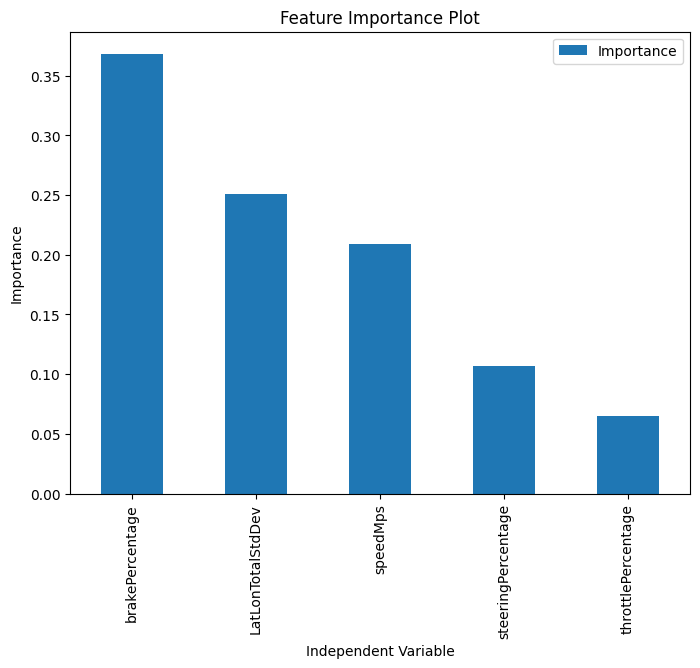

In [157]:
feat_importances = pd.DataFrame( model.feature_importances_, index = X_colnames, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot' )

plt.show()

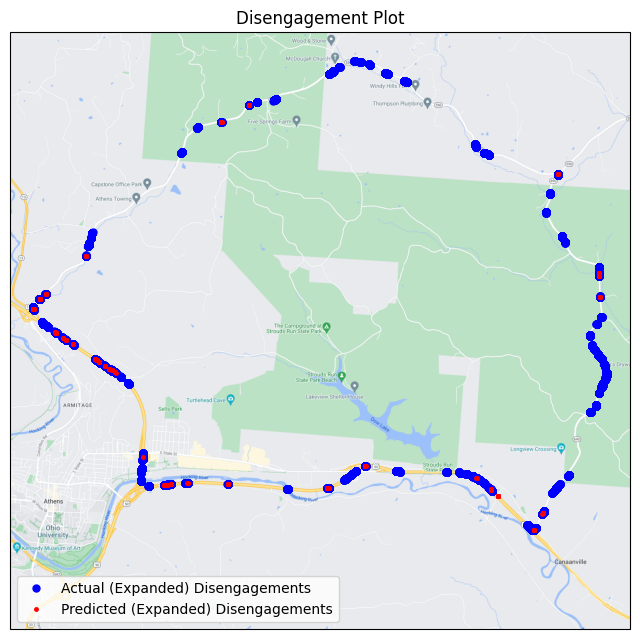

In [158]:
plt.figure( figsize = ( 8, 8 ) )

#

red_preprocessed_df = pd.concat( red_preprocessed_dfs )

#

minLat = np.min( np.array( red_preprocessed_df[ 'latitude' ] ) )

maxLat = np.max( np.array( red_preprocessed_df[ 'latitude' ] ) )

minLon = np.min( np.array( red_preprocessed_df[ 'longitude' ] ) )

maxLon = np.max( np.array( red_preprocessed_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

del red_preprocessed_df

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

red_testing_df = pd.concat( red_testing_dfs )

red_testing_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test

#

actual_disengagement_lat_list_test =  red_testing_df[ red_testing_df[ 'BinaryDisengagementExpanded' ] == 1 ][ 'latitude' ]

actual_disengagement_lon_list_test =  red_testing_df[ red_testing_df[ 'BinaryDisengagementExpanded' ] == 1 ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  red_testing_df[ red_testing_df[ 'pred_BinaryDisengagementExpanded' ] == 1 ][ 'latitude' ]

pred_disengagement_lon_list_test =  red_testing_df[ red_testing_df[ 'pred_BinaryDisengagementExpanded' ] == 1 ][ 'longitude' ]

#

del red_testing_df

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot' )

plt.legend()

plt.show()

In [159]:
green_train_gmIDs = [ 
'3ec95686-f053-11ee-b988-fb353e7798cd',
'b31aca98-cb95-11ee-909c-e1dc60cf66f9',
'25e27b86-f06a-11ee-b9a3-fb353e7798cd',
'bf9157f0-f16b-11ee-ba9e-fb353e7798cd',
'51b74168-f19d-11ee-babf-fb353e7798cd',
'de493be2-f10f-11ee-ba4b-fb353e7798cd',
'ece2a8be-f047-11ee-b97d-fb353e7798cd',
'044d976e-f0e5-11ee-ba20-fb353e7798cd',
'98692fde-f1a4-11ee-bac6-fb353e7798cd',
'5afabc8c-f035-11ee-b966-fb353e7798cd',
'072ef896-cbac-11ee-909c-e1dc60cf66f9',
'c59a54e0-f179-11ee-baab-fb353e7798cd',
'bbbd0cc6-f0dc-11ee-ba1e-fb353e7798cd',
'ba87f3ec-f07e-11ee-b9b4-fb353e7798cd',
'96ceec56-f1cf-11ee-bae4-fb353e7798cd',
'40706f50-f03b-11ee-b96e-fb353e7798cd',
'f570c51c-f15d-11ee-ba91-fb353e7798cd',
'f12112ba-f1c0-11ee-bada-fb353e7798cd',
'961fd9cc-f103-11ee-ba3f-fb353e7798cd',
'5f7ce340-f1c8-11ee-bae0-fb353e7798cd',
'cf7148d8-f058-11ee-b98a-fb353e7798cd',
'848e44a6-f134-11ee-ba6d-fb353e7798cd',
'3a7dc9a6-f042-11ee-b974-fb353e7798cd',
'c9be2042-f0de-11ee-ba1e-fb353e7798cd',
'9736e77c-f187-11ee-bab6-fb353e7798cd',
'5fc763f6-f1ab-11ee-bacd-fb353e7798cd',
'4c88757c-f157-11ee-ba89-fb353e7798cd',
'a231c0b0-f142-11ee-ba76-fb353e7798cd',
'53fad09e-f0f7-11ee-ba2f-fb353e7798cd',
'5c7a9ab2-f13b-11ee-ba72-fb353e7798cd',
'4cf81634-f238-11ee-bb34-fb353e7798cd',
'a08a8c7e-f1fb-11ee-bb05-fb353e7798cd',
'3ed4aa16-f1d6-11ee-bae6-fb353e7798cd',
'25135418-f250-11ee-bb4a-fb353e7798cd',
'c1b320e2-f079-11ee-b9b0-fb353e7798cd',
'43abeb00-f206-11ee-bb07-fb353e7798cd',
'fe0395f0-f1ea-11ee-baf9-fb353e7798cd',
'3d8020aa-cb7f-11ee-909c-e1dc60cf66f9',
'14b6bc9c-f064-11ee-b998-fb353e7798cd',
'870cfd32-f1b9-11ee-bad5-fb353e7798cd',
'c2f54552-f06f-11ee-b9a9-fb353e7798cd',
'dea29156-f123-11ee-ba5d-fb353e7798cd',
'3c415ade-d353-11ee-b437-336917683bb8',
'a901fe40-f0fd-11ee-ba39-fb353e7798cd',
'c4146d46-f074-11ee-b9ac-fb353e7798cd',
'de226278-f25a-11ee-bb4e-fb353e7798cd',
'd7cb9c92-f164-11ee-ba97-fb353e7798cd',
'88b0613a-d35d-11ee-b437-336917683bb8',
'c4fca7bc-f18e-11ee-bab8-fb353e7798cd',
'ed352100-cba0-11ee-909c-e1dc60cf66f9',
'cbdc93f4-f255-11ee-bb4e-fb353e7798cd',
'8e5c4fc2-f149-11ee-ba7f-fb353e7798cd',
'bb4d37d4-f109-11ee-ba46-fb353e7798cd',
'236836f6-f1dd-11ee-bae8-fb353e7798cd',
'7948628e-f20b-11ee-bb0f-fb353e7798cd',
'c14299be-f180-11ee-bab0-fb353e7798cd',
'73bc30cc-f150-11ee-ba84-fb353e7798cd',
'7e3d64da-f12d-11ee-ba68-fb353e7798cd',
'837fc882-cb5a-11ee-909c-e1dc60cf66f9',
'f8fd0fd8-f243-11ee-bb3f-fb353e7798cd',
'58d78342-f24a-11ee-bb45-fb353e7798cd',
'8adb6498-f04d-11ee-b981-fb353e7798cd',
'271fee10-cb8b-11ee-909c-e1dc60cf66f9',
'99b9f446-f1b2-11ee-bad3-fb353e7798cd'
]

green_training_dfs, green_testing_dfs = [], []

for df in green_preprocessed_dfs:

    if df[ 'groupMetadataID' ][ 0 ] in green_train_gmIDs:

        green_training_dfs.append( df )

    else:

        green_testing_dfs.append( df )

In [160]:
for df in green_testing_dfs:

    print( f"'{ df[ 'groupMetadataID' ][ 0 ] }'," )

'e9a1d768-f23d-11ee-bb39-fb353e7798cd',
'7a22a34c-f1f0-11ee-bafe-fb353e7798cd',
'0f3cdf60-f1f6-11ee-bb00-fb353e7798cd',
'25641404-cb66-11ee-909c-e1dc60cf66f9',
'a6539bd2-cb72-11ee-909c-e1dc60cf66f9',
'1c74d294-f1e4-11ee-baf0-fb353e7798cd',
'7f824ea2-f05e-11ee-b993-fb353e7798cd',
'd454c586-f11c-11ee-ba55-fb353e7798cd',
'5774dcde-f196-11ee-babe-fb353e7798cd',
'f9c5e53e-f0ea-11ee-ba28-fb353e7798cd',
'9df14b4e-f172-11ee-baa6-fb353e7798cd',
'fa9cba86-f0f0-11ee-ba2a-fb353e7798cd',
'd1a3a310-f091-11ee-b9ce-fb353e7798cd',
'd846a080-f115-11ee-ba51-fb353e7798cd',
'8b0593cc-cb4e-11ee-909c-e1dc60cf66f9',
'b3ee0dd8-f0d7-11ee-ba18-fb353e7798cd',
'df6c3fb4-f200-11ee-bb07-fb353e7798cd',


In [161]:
def function_to_maximize( min_samples_split, min_samples_leaf ):

    value = cfs.BinaryClassification_DecisionTree_CV( train_dfs = green_training_dfs, \
                                                      X_colnames = X_colnames, \
                                                      y_colname = y_colname, \
                                                      metric_function = cfs.mf_fbeta_score, \
                                                      dt_random_state = 0, \
                                                      cv_num_of_splits = 5, \
                                                      cv_shuffle = False, \
                                                      cv_random_state = None, \
                                                      y_labels = [ 0, 1 ], \
                                                      criterion = 'entropy', \
                                                      min_samples_split = round( min_samples_split ),
                                                      min_samples_leaf = round( min_samples_leaf ) )

    return value

In [162]:
parameter_bounds = {

    'min_samples_split': ( 2, 200 ),

    'min_samples_leaf': ( 1, 200 )
}

optimizer = BayesianOptimization( f = function_to_maximize, \
                                  pbounds = parameter_bounds, \
                                  random_state = 0, \
                                  verbose = 2 )

optimizer.maximize( n_iter = 75, init_points = 25 )

best_params_bayes = optimizer.max[ 'params' ]

best_params_bayes[ 'min_samples_split' ] = round( best_params_bayes[ 'min_samples_split' ] )

best_params_bayes[ 'min_samples_leaf' ] = round( best_params_bayes[ 'min_samples_leaf' ] )

best_score_bayes = optimizer.max['target']

print( f'Tuned Hyperparameters: { best_params_bayes }' )

print( f'Best F1_Score: { best_score_bayes }' )

|   iter    |  target   | min_sa... | min_sa... |
-------------------------------------------------
| 1         | 0.09584   | 110.2     | 143.6     |
| 2         | 0.1025    | 120.9     | 109.9     |
| 3         | 0.1147    | 85.31     | 129.9     |
| 4         | 0.1128    | 88.08     | 178.6     |
| 5         | 0.07185   | 192.8     | 77.92     |
| 6         | 0.07925   | 158.6     | 106.7     |
| 7         | 0.0977    | 114.0     | 185.3     |
| 8         | 0.1094    | 15.14     | 19.25     |
| 9         | 0.1169    | 5.023     | 166.9     |
| 10        | 0.07183   | 155.9     | 174.3     |
| 11        | 0.06798   | 195.7     | 160.2     |
| 12        | 0.1128    | 92.83     | 156.5     |
| 13        | 0.1331    | 24.54     | 128.7     |
| 14        | 0.134     | 29.53     | 189.0     |
| 15        | 0.09758   | 104.8     | 84.1      |
| 16        | 0.13      | 53.65     | 155.3     |
| 17        | 0.1148    | 91.77     | 114.5     |
| 18        | 0.1217    | 4.739     | 124.3     |


In [163]:
cm_values, model, y_test, y_pred_test = cfs.BinaryClassification_DecisionTree( train_dfs = green_training_dfs, \
                                                                               test_dfs = green_testing_dfs, \
                                                                               X_colnames = X_colnames, \
                                                                               y_colname = y_colname, \
                                                                               dt_random_state = 0, \
                                                                               y_labels = [ 0, 1 ], \
                                                                               **best_params_bayes )

tn, fp, fn, tp = cm_values.values()

In [164]:
_ = cfs.ML_metrics( tn = tn, fp = fp, fn = fn, tp = tp, beta = 1, display = True )

True_Positives: 195, False_Positives: 1026
False_Negatives: 2967, True_Negatives: 450381

Positive_Precision: 0.160

Positive_Recall: 0.062

F1_Score: 0.089

Accuracy: 0.991
Balanced_Accuracy: 0.528


In [165]:
green_testing_df = pd.concat( green_testing_dfs )

#

unique_disengagement_recall_ = cfs.unique_disengagement_recall( y_true = y_test, \
                                                                y_pred = y_pred_test, \
                                                                true_DisengagementExpandedID_col = green_testing_df[ 'DisengagementExpandedID' ] )

#

del green_testing_df

for key, val in unique_disengagement_recall_.items():

    if ( key == 'unique_disengagement_recall' ):

        print( f'{ key }: { val:.3f}' )

    else:

        print( f'{ key }: { val }' )

unique_disengagement_recall: 0.209
num_of_unique_tp_DisengagementIDs: 19
num_of_unique_DisengagementIDs: 91


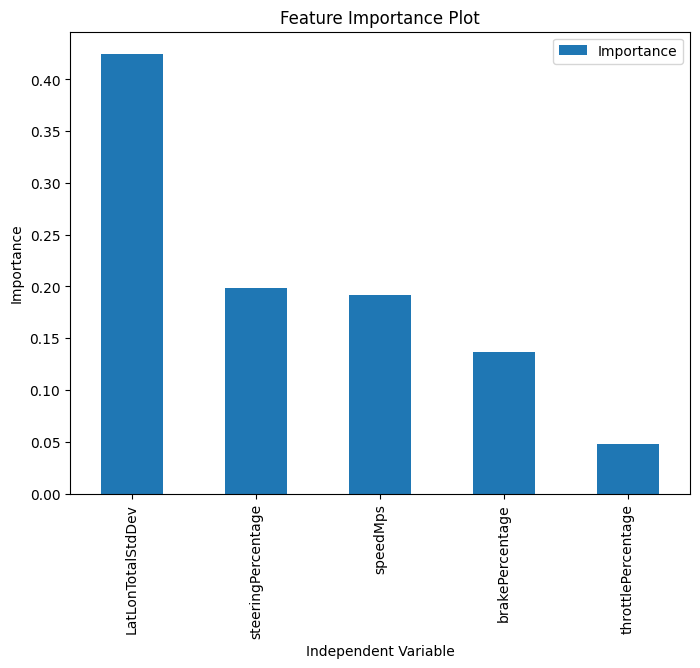

In [166]:
feat_importances = pd.DataFrame( model.feature_importances_, index = X_colnames, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot' )

plt.show()

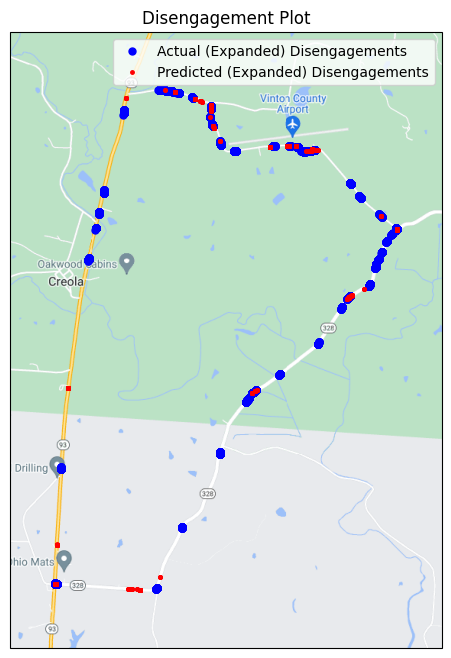

In [167]:
plt.figure( figsize = ( 8, 8 ) )

#

green_preprocessed_df = pd.concat( green_preprocessed_dfs )

#

minLat = np.min( np.array( green_preprocessed_df[ 'latitude' ] ) )

maxLat = np.max( np.array( green_preprocessed_df[ 'latitude' ] ) )

minLon = np.min( np.array( green_preprocessed_df[ 'longitude' ] ) )

maxLon = np.max( np.array( green_preprocessed_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

del green_preprocessed_df

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

green_testing_df = pd.concat( green_testing_dfs )

green_testing_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test

#

actual_disengagement_lat_list_test =  green_testing_df[ green_testing_df[ 'BinaryDisengagementExpanded' ] == 1 ][ 'latitude' ]

actual_disengagement_lon_list_test =  green_testing_df[ green_testing_df[ 'BinaryDisengagementExpanded' ] == 1 ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  green_testing_df[ green_testing_df[ 'pred_BinaryDisengagementExpanded' ] == 1 ][ 'latitude' ]

pred_disengagement_lon_list_test =  green_testing_df[ green_testing_df[ 'pred_BinaryDisengagementExpanded' ] == 1 ][ 'longitude' ]

#

del green_testing_df

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot' )

plt.legend()

plt.show()

In [168]:
blue_train_gmIDs = [ 
'7228e03a-ebf0-11ee-b297-3b0ad9d5d6c6',
'8c57e8ac-dbec-11ee-a158-97f8443fd730',
'17876fec-ea66-11ee-b297-3b0ad9d5d6c6',
'd1d090d4-ea7c-11ee-b297-3b0ad9d5d6c6',
'ed7f2038-ea1e-11ee-b297-3b0ad9d5d6c6',
'6af236d6-d98f-11ee-a158-97f8443fd730',
'64737d98-d312-11ee-b437-336917683bb8',
'5240e750-ec30-11ee-b297-3b0ad9d5d6c6',
'7613801a-edcb-11ee-9385-ef789ffde1d3',
'68c289fa-dbd4-11ee-a158-97f8443fd730',
'76683d3c-db18-11ee-a158-97f8443fd730',
'69ab88ec-dc17-11ee-a158-97f8443fd730',
'7f09f6c6-a5b0-11ee-88ec-eb6a8d5269b4',
'3d2a80f0-ec81-11ee-b297-3b0ad9d5d6c6',
'feaf2ba8-d28d-11ee-b437-336917683bb8',
'e2079a78-dc1d-11ee-a158-97f8443fd730',
'b224ef9c-ec10-11ee-b297-3b0ad9d5d6c6',
'ba28b352-ec8f-11ee-b297-3b0ad9d5d6c6',
'59c189d8-ed54-11ee-9385-ef789ffde1d3',
'2d35c522-eba2-11ee-b297-3b0ad9d5d6c6',
'3343fd3c-eb87-11ee-b297-3b0ad9d5d6c6',
'c0624e24-d9aa-11ee-a158-97f8443fd730',
'a253145a-d2a6-11ee-b437-336917683bb8',
'9830d896-d2dc-11ee-b437-336917683bb8',
'aa86a660-dc05-11ee-a158-97f8443fd730',
'90101c36-a621-11ee-88ec-eb6a8d5269b4',
'82d39c74-ea59-11ee-b297-3b0ad9d5d6c6',
'f9d62032-db2a-11ee-a158-97f8443fd730',
'af10e22a-ebb1-11ee-b297-3b0ad9d5d6c6',
'47561998-d9c3-11ee-a158-97f8443fd730',
'64875cc0-d054-11ee-9435-f7e542e2436c',
'df8e3742-ec54-11ee-b297-3b0ad9d5d6c6',
'3a2a78cc-db21-11ee-a158-97f8443fd730',
'21a9830-ece6-11ee-b297-3b0ad9d5d6c6',
'2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4',
'4d0254fc-ec73-11ee-b297-3b0ad9d5d6c6',
'dc39aa14-db32-11ee-a158-97f8443fd730',
'25d3bdc8-ecbc-11ee-b297-3b0ad9d5d6c6',
'8b6a6cfc-ed6d-11ee-9385-ef789ffde1d3',
'e6d7d384-db40-11ee-a158-97f8443fd730',
'a17c1280-ea10-11ee-b297-3b0ad9d5d6c6',
'36663b02-ea87-11ee-b297-3b0ad9d5d6c6',
'71a18322-ecab-11ee-b297-3b0ad9d5d6c6',
'cf6fdf3a-eaa3-11ee-b297-3b0ad9d5d6c6',
'57d240d6-ea4d-11ee-b297-3b0ad9d5d6c6',
'baf0e4be-bede-11ee-835b-599066b5eb60',
'530de03a-ed79-11ee-9385-ef789ffde1d3',
'43914d48-ed85-11ee-9385-ef789ffde1d3',
'a7c98b32-ebc2-11ee-b297-3b0ad9d5d6c6',
'fc119dfc-eb67-11ee-b297-3b0ad9d5d6c6',
'c7c02bda-ebe0-11ee-b297-3b0ad9d5d6c6',
'39ba7438-d0d5-11ee-9435-f7e542e2436c',
'e8a8b2be-edbf-11ee-9385-ef789ffde1d3',
'3ea96640-ea37-11ee-b297-3b0ad9d5d6c6',
'21376e38-ec01-11ee-b297-3b0ad9d5d6c6',
'513a670c-eea9-11ee-9385-ef789ffde1d3',
'06cbdbc0-db4d-11ee-a158-97f8443fd730',
'559495ca-d270-11ee-b437-336917683bb8',
'04151804-ec20-11ee-b297-3b0ad9d5d6c6',
'd62ee6e8-ed02-11ee-9385-ef789ffde1d3',
'154fab12-a43f-11ee-88ec-eb6a8d5269b4',
'58263e34-a45c-11ee-88ec-eb6a8d5269b4',
'acd71bc0-ecf4-11ee-9385-ef789ffde1d3',
'3441fc36-ecca-11ee-b297-3b0ad9d5d6c6',
'f671c05c-a5e4-11ee-88ec-eb6a8d5269b4',
'c8f54ac0-ebd2-11ee-b297-3b0ad9d5d6c6',
'326699c2-ecd8-11ee-b297-3b0ad9d5d6c6',
'3ce8a358-edd8-11ee-9385-ef789ffde1d3',
'286c70cc-d2f7-11ee-b437-336917683bb8',
'20cbfe8c-ea2b-11ee-b297-3b0ad9d5d6c6',
'c9023e32-ed90-11ee-9385-ef789ffde1d3',
'f0bcec4e-ed3e-11ee-9385-ef789ffde1d3',
'd94ef300-ed60-11ee-9385-ef789ffde1d3',
'e269948a-ed9d-11ee-9385-ef789ffde1d3',
'f6ac3c82-a445-11ee-88ec-eb6a8d5269b4',
'80340ab8-d054-11ee-9435-f7e542e2436c',
'b76f33be-ea61-11ee-b297-3b0ad9d5d6c6'
]

blue_training_dfs, blue_testing_dfs = [], []

for df in blue_preprocessed_dfs:

    if df[ 'groupMetadataID' ][ 0 ] in blue_train_gmIDs:

        blue_training_dfs.append( df )

    else:

        blue_testing_dfs.append( df )

In [169]:
for df in blue_testing_dfs:

    print( f"'{ df[ 'groupMetadataID' ][ 0 ] }'," )

'19b7ebd0-d9b7-11ee-a158-97f8443fd730',
'da853e0c-a10f-11ee-981c-d126ddbe9afa',
'04115e66-ea91-11ee-b297-3b0ad9d5d6c6',
'721a9830-ece6-11ee-b297-3b0ad9d5d6c6',
'5976b77a-a504-11ee-88ec-eb6a8d5269b4',
'ba6e1072-9524-11ee-956e-9da2d070324c',
'cb205756-ec43-11ee-b297-3b0ad9d5d6c6',
'88180f82-ed4f-11ee-9385-ef789ffde1d3',
'787d9684-d2c2-11ee-b437-336917683bb8',
'60546ef4-edaa-11ee-9385-ef789ffde1d3',
'c335d84c-a45c-11ee-88ec-eb6a8d5269b4',
'6d62da08-ec9d-11ee-b297-3b0ad9d5d6c6',
'e9d67bf2-ec35-11ee-b297-3b0ad9d5d6c6',
'0f4f0a06-ea98-11ee-b297-3b0ad9d5d6c6',
'70060810-eb59-11ee-b297-3b0ad9d5d6c6',
'5f6573ba-ed2f-11ee-9385-ef789ffde1d3',
'20f0b890-ec64-11ee-b297-3b0ad9d5d6c6',
'5fcc4fd8-ea71-11ee-b297-3b0ad9d5d6c6',
'64bbe8e0-eb94-11ee-b297-3b0ad9d5d6c6',
'75f83e28-eb77-11ee-b297-3b0ad9d5d6c6',
'aef91c4a-ede5-11ee-9385-ef789ffde1d3',


In [170]:
def function_to_maximize( min_samples_split, min_samples_leaf ):

    value = cfs.BinaryClassification_DecisionTree_CV( train_dfs = blue_training_dfs, \
                                                      X_colnames = X_colnames, \
                                                      y_colname = y_colname, \
                                                      metric_function = cfs.mf_fbeta_score, \
                                                      dt_random_state = 0, \
                                                      cv_num_of_splits = 5, \
                                                      cv_shuffle = False, \
                                                      cv_random_state = None, \
                                                      y_labels = [ 0, 1 ], \
                                                      criterion = 'entropy', \
                                                      min_samples_split = round( min_samples_split ),
                                                      min_samples_leaf = round( min_samples_leaf ) )

    return value

In [171]:
parameter_bounds = {

    'min_samples_split': ( 2, 500 ),

    'min_samples_leaf': ( 1, 500 )
}

optimizer = BayesianOptimization( f = function_to_maximize, \
                                  pbounds = parameter_bounds, \
                                  random_state = 0, \
                                  verbose = 2 )

optimizer.maximize( n_iter = 75, init_points = 25 )

best_params_bayes = optimizer.max[ 'params' ]

best_params_bayes[ 'min_samples_split' ] = round( best_params_bayes[ 'min_samples_split' ] )

best_params_bayes[ 'min_samples_leaf' ] = round( best_params_bayes[ 'min_samples_leaf' ] )

best_score_bayes = optimizer.max['target']

print( f'Tuned Hyperparameters: { best_params_bayes }' )

print( f'Best F1_Score: { best_score_bayes }' )

|   iter    |  target   | min_sa... | min_sa... |
-------------------------------------------------
| 1         | 0.1359    | 274.9     | 358.2     |
| 2         | 0.136     | 301.8     | 273.4     |
| 3         | 0.1451    | 212.4     | 323.7     |
| 4         | 0.1456    | 219.4     | 446.1     |
| 5         | 0.1306    | 481.9     | 193.0     |
| 6         | 0.1313    | 396.1     | 265.4     |
| 7         | 0.1359    | 284.5     | 462.9     |
| 8         | 0.161     | 36.45     | 45.39     |
| 9         | 0.1596    | 11.09     | 416.6     |
| 10        | 0.1313    | 389.3     | 435.3     |
| 11        | 0.1306    | 489.3     | 400.0     |
| 12        | 0.143     | 231.3     | 390.7     |
| 13        | 0.164     | 60.02     | 320.7     |
| 14        | 0.1622    | 72.53     | 472.4     |
| 15        | 0.1376    | 261.4     | 208.5     |
| 16        | 0.1567    | 133.0     | 387.6     |
| 17        | 0.1432    | 228.6     | 285.1     |
| 18        | 0.1592    | 10.38     | 309.6     |


In [172]:
cm_values, model, y_test, y_pred_test = cfs.BinaryClassification_DecisionTree( train_dfs = blue_training_dfs, \
                                                                               test_dfs = blue_testing_dfs, \
                                                                               X_colnames = X_colnames, \
                                                                               y_colname = y_colname, \
                                                                               dt_random_state = 0, \
                                                                               y_labels = [ 0, 1 ], \
                                                                               **best_params_bayes )

tn, fp, fn, tp = cm_values.values()

In [173]:
_ = cfs.ML_metrics( tn = tn, fp = fp, fn = fn, tp = tp, beta = 1, display = True )

True_Positives: 573, False_Positives: 2143
False_Negatives: 7043, True_Negatives: 1126512

Positive_Precision: 0.211

Positive_Recall: 0.075

F1_Score: 0.111

Accuracy: 0.992
Balanced_Accuracy: 0.535


In [174]:
blue_testing_df = pd.concat( blue_testing_dfs )

#

unique_disengagement_recall_ = cfs.unique_disengagement_recall( y_true = y_test, \
                                                                y_pred = y_pred_test, \
                                                                true_DisengagementExpandedID_col = blue_testing_df[ 'DisengagementExpandedID' ] )

#

del blue_testing_df

for key, val in unique_disengagement_recall_.items():

    if ( key == 'unique_disengagement_recall' ):

        print( f'{ key }: { val:.3f}' )

    else:

        print( f'{ key }: { val }' )

unique_disengagement_recall: 0.315
num_of_unique_tp_DisengagementIDs: 67
num_of_unique_DisengagementIDs: 213


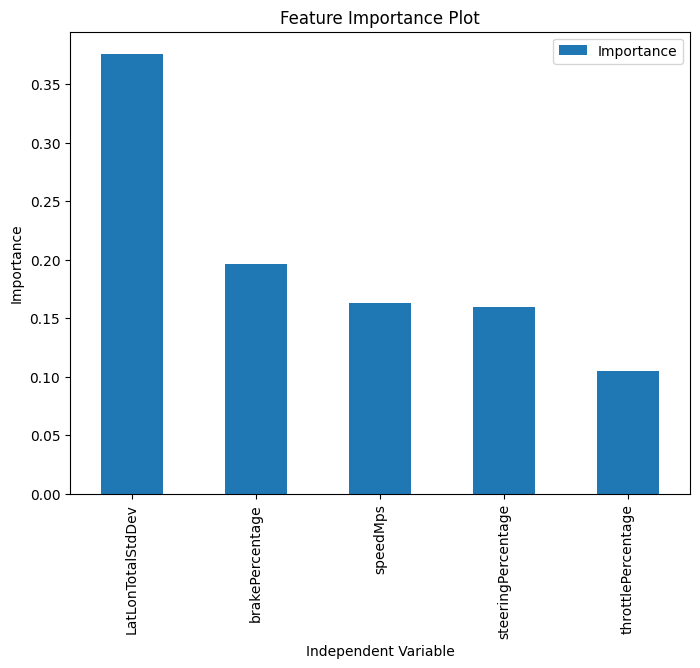

In [175]:
feat_importances = pd.DataFrame( model.feature_importances_, index = X_colnames, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot' )

plt.show()

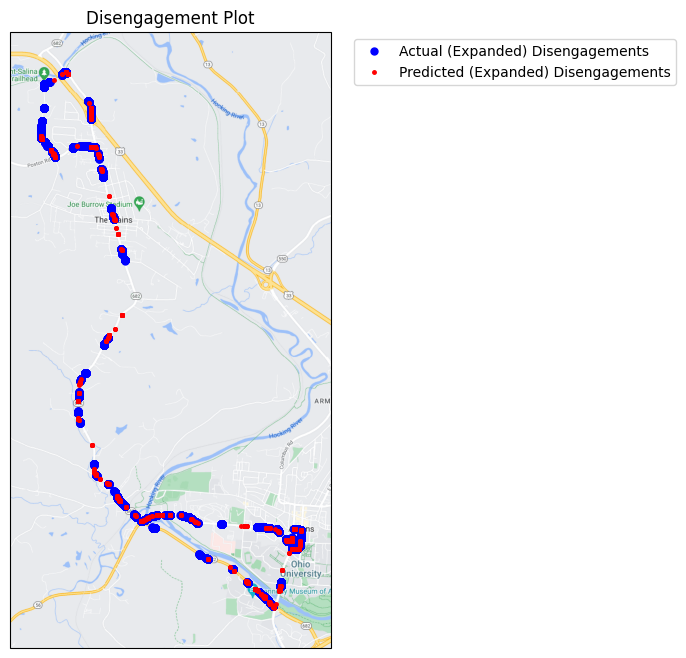

In [176]:
plt.figure( figsize = ( 8, 8 ) )

#

blue_preprocessed_df = pd.concat( blue_preprocessed_dfs )

#

minLat = np.min( np.array( blue_preprocessed_df[ 'latitude' ] ) )

maxLat = np.max( np.array( blue_preprocessed_df[ 'latitude' ] ) )

minLon = np.min( np.array( blue_preprocessed_df[ 'longitude' ] ) )

maxLon = np.max( np.array( blue_preprocessed_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

del blue_preprocessed_df

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

blue_testing_df = pd.concat( blue_testing_dfs )

blue_testing_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test

#

actual_disengagement_lat_list_test =  blue_testing_df[ blue_testing_df[ 'BinaryDisengagementExpanded' ] == 1 ][ 'latitude' ]

actual_disengagement_lon_list_test =  blue_testing_df[ blue_testing_df[ 'BinaryDisengagementExpanded' ] == 1 ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  blue_testing_df[ blue_testing_df[ 'pred_BinaryDisengagementExpanded' ] == 1 ][ 'latitude' ]

pred_disengagement_lon_list_test =  blue_testing_df[ blue_testing_df[ 'pred_BinaryDisengagementExpanded' ] == 1 ][ 'longitude' ]

#

del blue_testing_df

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot' )

plt.legend( bbox_to_anchor = ( 1.05, 1.0 ), loc = 'upper left' )

plt.show()